# Visualización de Resultados de Modelos

Este notebook permite cargar y visualizar los resultados de entrenamiento de los modelos de clasificación de estadios de sueño.

Carga métricas desde archivos JSON generados por `src/models.py` y genera visualizaciones interactivas.

**Modelos soportados:**
- Random Forest
- XGBoost  
- CNN1D (Deep Learning)
- LSTM (Deep Learning)


## Configuración inicial


In [27]:
import json
from pathlib import Path
from statistics import NormalDist

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

sns.set_theme(style="whitegrid", palette="deep")

PROJECT_ROOT = Path("..").resolve()
MODELS_DIR = PROJECT_ROOT / "models"
ARTIFACTS_DIR = PROJECT_ROOT / "artifacts"

STAGE_ORDER = ["W", "N1", "N2", "N3", "REM"]
STAGE_COLORS = {
    "W": "#fdae61",
    "N1": "#fee090",
    "N2": "#abd9e9",
    "N3": "#2c7bb6",
    "REM": "#d7191c",
}

EPS = 1e-12


def load_metrics(path: Path) -> dict:
    """Carga métricas desde un archivo JSON."""
    with open(path) as f:
        return json.load(f)


def wilson_ci(
    successes: float, total: float, alpha: float = 0.05
) -> tuple[float, float]:
    """Intervalo de confianza de Wilson para proporciones (binomial)."""
    if total <= 0:
        return (np.nan, np.nan)
    z = NormalDist().inv_cdf(1 - alpha / 2)
    phat = successes / total
    denom = 1 + (z**2) / total
    center = (phat + (z**2) / (2 * total)) / denom
    margin = (
        z * np.sqrt((phat * (1 - phat) / total) + ((z**2) / (4 * total**2)))
    ) / denom
    return (max(0, center - margin), min(1, center + margin))


def compute_class_metrics(
    cm: np.ndarray, labels=STAGE_ORDER, alpha: float = 0.05
) -> pd.DataFrame:
    """Calcula métricas por clase a partir de la matriz de confusión."""
    cm = np.asarray(cm)
    metrics = []
    for idx, label in enumerate(labels):
        tp = cm[idx, idx]
        fn = cm[idx, :].sum() - tp
        fp = cm[:, idx].sum() - tp
        tn = cm.sum() - tp - fn - fp

        support = tp + fn
        predicted = tp + fp

        precision = tp / (predicted + EPS)
        recall = tp / (support + EPS)
        specificity = tn / (tn + fp + EPS)
        npv = tn / (tn + fn + EPS)
        f1 = 2 * precision * recall / (precision + recall + EPS)
        fpr = fp / (fp + tn + EPS)
        fnr = fn / (fn + tp + EPS)
        fdr = fp / (fp + tp + EPS)

        recall_ci_low, recall_ci_high = wilson_ci(tp, support, alpha=alpha)
        spec_ci_low, spec_ci_high = wilson_ci(tn, tn + fp, alpha=alpha)

        metrics.append(
            {
                "Stage": label,
                "support": support,
                "precision": precision,
                "recall": recall,
                "specificity": specificity,
                "npv": npv,
                "f1": f1,
                "fpr": fpr,
                "fnr": fnr,
                "fdr": fdr,
                "recall_ci_low": recall_ci_low,
                "recall_ci_high": recall_ci_high,
                "spec_ci_low": spec_ci_low,
                "spec_ci_high": spec_ci_high,
            }
        )

    return pd.DataFrame(metrics)


def summarize_class_metrics(df: pd.DataFrame) -> dict[str, float]:
    """Resumen macro con métricas robustas a desbalance (balanced accuracy)."""
    n_classes = len(df)
    chance = 1 / n_classes if n_classes else np.nan
    balanced_accuracy = df["recall"].mean()
    macro_specificity = df["specificity"].mean()
    return {
        "balanced_accuracy": balanced_accuracy,
        "macro_specificity": macro_specificity,
        "macro_precision": df["precision"].mean(),
        "macro_f1": df["f1"].mean(),
        "gmean_sens_spec": np.sqrt(balanced_accuracy * macro_specificity),
        "chance_accuracy": chance,
        "balanced_accuracy_lift": (balanced_accuracy / chance - 1)
        if chance
        else np.nan,
    }


def most_confused_pairs(
    cm: np.ndarray, labels=STAGE_ORDER, top_n: int = 5
) -> pd.DataFrame:
    """Top pares de confusión (verdadero vs predicho) ordenados por frecuencia."""
    cm = np.asarray(cm)
    records = []
    for i, true_label in enumerate(labels):
        row_sum = cm[i, :].sum()
        for j, pred_label in enumerate(labels):
            if i == j:
                continue
            count = int(cm[i, j])
            if count > 0:
                records.append(
                    {
                        "Verdadero": true_label,
                        "Predicho": pred_label,
                        "Conteo": count,
                        "Proporción_sobre_clase": count / (row_sum + EPS),
                    }
                )

    if not records:
        return pd.DataFrame(
            columns=["Verdadero", "Predicho", "Conteo", "Proporción_sobre_clase"]
        )

    df = pd.DataFrame(records)
    return df.sort_values(by="Conteo", ascending=False).head(top_n)


MODEL_PATHS = {
    "random_forest": MODELS_DIR / "rf_opt_bayes_best" / "random_forest_metrics.json",
    "xgboost": MODELS_DIR / "xgb_loso_best" / "xgboost_metrics.json",
    "cnn1d": ARTIFACTS_DIR
    / "cnn1d_full_20251210_201502_artifacts"
    / "cnn1d_full_20251210_201502_results.json",
    "lstm_unidir": ARTIFACTS_DIR
    / "lstm_full_unidir_artifacts"
    / "lstm_full_20251210_193039_results.json",
    "lstm_bidir": ARTIFACTS_DIR
    / "lstm_full_bidir_artifacts"
    / "lstm_full_20251211_031820_results.json",
    "lstm_bidir_attention": ARTIFACTS_DIR
    / "lstm_full_bidir_attention_artifacts"
    / "lstm_full_20251211_145034_results.json",
}

AVAILABLE_MODELS = list(MODEL_PATHS.keys())

print("Modelos disponibles:", AVAILABLE_MODELS)

Modelos disponibles: ['random_forest', 'xgboost', 'cnn1d', 'lstm_unidir', 'lstm_bidir', 'lstm_bidir_attention']


## Cargar métricas de un modelo


In [28]:
# Cambiar según el modelo que quieras visualizar
model_type = "xgboost"  # Opciones: "random_forest", "xgboost", "cnn1d", "lstm_unidir", "lstm_bidir", "lstm_bidir_attention"

metrics_path = MODEL_PATHS.get(model_type)

if metrics_path and metrics_path.exists():
    metrics = load_metrics(metrics_path)
    print(f"Métricas cargadas para {model_type}")
    print(f"Timestamp: {metrics.get('timestamp', 'N/A')}")
    print(
        f"Tipo de modelo: {metrics.get('model_type', metrics.get('model_name', 'N/A'))}"
    )
    print(
        f"Parámetros/Config: {metrics.get('model_params', metrics.get('config', {}))}"
    )
else:
    print(f"No se encontró archivo de métricas para {model_type}")
    print(f"Path buscado: {metrics_path}")
    print("\nModelos disponibles con archivos:")
    for name, path in MODEL_PATHS.items():
        status = "✓" if path.exists() else "✗"
        print(f"  {status} {name}: {path}")

Métricas cargadas para xgboost
Timestamp: 2025-12-08T18:37:24.109095
Tipo de modelo: xgboost
Parámetros/Config: {'n_estimators': 413, 'max_depth': 10, 'n_iter_optimize': 50, 'cv_folds_optimize': 3, 'optimize_storage': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'class_weight': None, 'learning_rate': 0.03313286416029904, 'subsample': 0.7443736026906934, 'colsample_bytree': 0.6223142659283984, 'min_child_weight': 4.0, 'gamma': 0.7123076394393054, 'reg_alpha': 0.00048606238525281066, 'reg_lambda': 0.026977435708790857, 'scale_pos_weight': None}


## Métricas generales


In [29]:
if "metrics" in metrics:
    m = metrics["metrics"]
    print("=" * 60)
    print("MÉTRICAS GENERALES")
    print("=" * 60)
    print(f"Accuracy:        {m.get('accuracy', 0):.4f}")
    print(f"Cohen's Kappa:   {m.get('kappa', 0):.4f}")
    print(f"F1-score (macro): {m.get('f1_macro', 0):.4f}")
    print(f"F1-score (weighted): {m.get('f1_weighted', 0):.4f}")

    if "cv_results" in metrics:
        cv = metrics["cv_results"]
        print("\nCross-Validation:")
        print(
            f"  Mean F1-macro: {cv.get('mean_score', 0):.4f} ± {cv.get('std_score', 0):.4f}"
        )

MÉTRICAS GENERALES
Accuracy:        0.7308
Cohen's Kappa:   0.6412
F1-score (macro): 0.7002
F1-score (weighted): 0.7374

Cross-Validation:
  Mean F1-macro: 0.6796 ± 0.0985


## Matriz de confusión


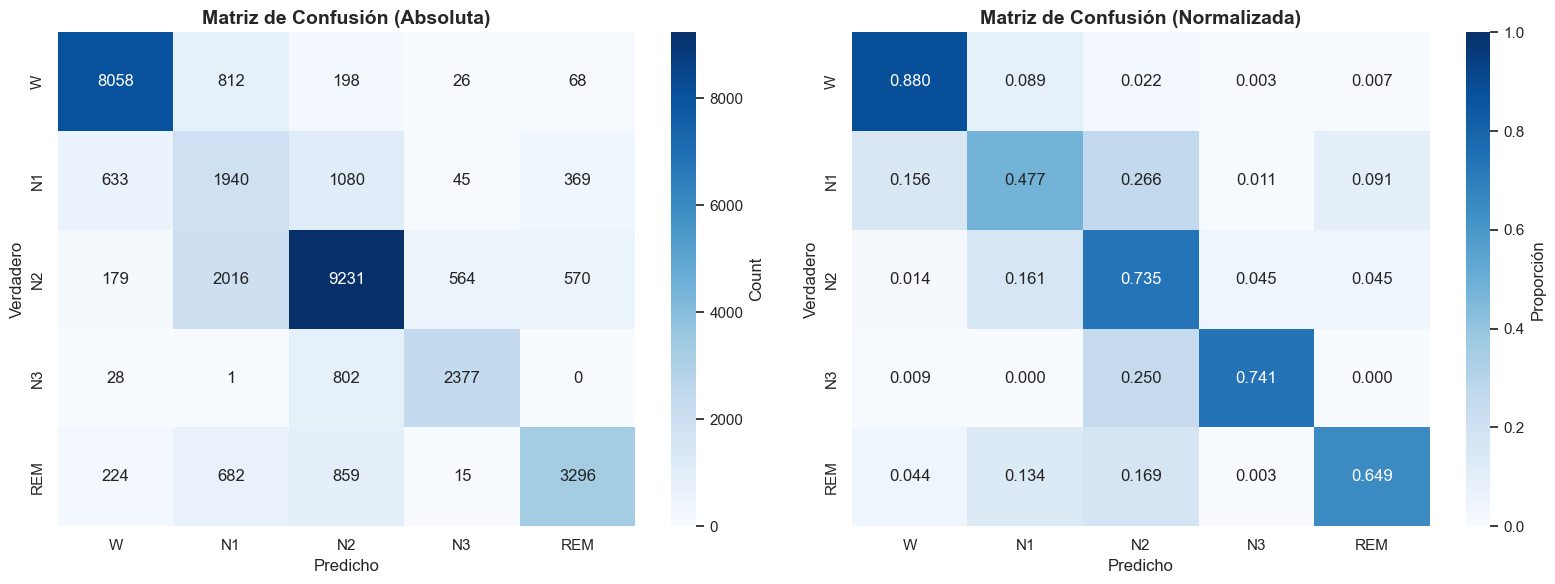

In [30]:
if "confusion_matrix" in metrics:
    cm = np.array(metrics["confusion_matrix"])

    # Normalizar por filas (recall por clase)
    cm_normalized = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-10)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Matriz absoluta
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=STAGE_ORDER,
        yticklabels=STAGE_ORDER,
        ax=axes[0],
        cbar_kws={"label": "Count"},
    )
    axes[0].set_title("Matriz de Confusión (Absoluta)", fontsize=14, fontweight="bold")
    axes[0].set_ylabel("Verdadero", fontsize=12)
    axes[0].set_xlabel("Predicho", fontsize=12)

    # Matriz normalizada
    sns.heatmap(
        cm_normalized,
        annot=True,
        fmt=".3f",
        cmap="Blues",
        xticklabels=STAGE_ORDER,
        yticklabels=STAGE_ORDER,
        ax=axes[1],
        cbar_kws={"label": "Proporción"},
        vmin=0,
        vmax=1,
    )
    axes[1].set_title(
        "Matriz de Confusión (Normalizada)", fontsize=14, fontweight="bold"
    )
    axes[1].set_ylabel("Verdadero", fontsize=12)
    axes[1].set_xlabel("Predicho", fontsize=12)

    plt.tight_layout()
    plt.show()

## Análisis complementario

Se amplía el análisis para interpretar los resultados con mayor rigor: métricas derivadas de la matriz de confusión (recall, especificidad, precisión, NPV, tasas de error), intervalos de confianza binomiales (Wilson) por clase, balanceo de desempeño (balanced accuracy) y pares de confusión más frecuentes que indican errores sistemáticos.


Distribución de soportes por clase:


,Stage,support,proportion
0,W,"9,162",26.89%
1,N1,"4,067",11.94%
2,N2,"12,560",36.86%
3,N3,"3,208",9.42%
4,REM,"5,076",14.90%



Métricas por clase con IC 95% (Wilson):


,Stage,precision,recall,specificity,npv (TN rate),f1,fpr,fnr,fdr,recall_ci_low,recall_ci_high,spec_ci_low,spec_ci_high
0,W,0.883,0.880,0.957,0.956,0.881,0.043,0.120,0.117,0.873,0.886,0.955,0.960
1,N1,0.356,0.477,0.883,0.926,0.408,0.117,0.523,0.644,0.462,0.492,0.879,0.887
2,N2,0.759,0.735,0.863,0.848,0.747,0.137,0.265,0.241,0.727,0.743,0.859,0.868
3,N3,0.785,0.741,0.979,0.973,0.762,0.021,0.259,0.215,0.726,0.756,0.977,0.980
4,REM,0.766,0.649,0.965,0.940,0.703,0.035,0.351,0.234,0.636,0.662,0.963,0.967



Resumen macro robusto:
Balanced accuracy (sensibilidad macro): 0.696
Especificidad macro: 0.930
Precisión macro: 0.710
F1 macro: 0.700
G-mean (sensibilidad x especificidad): 0.805
Azar (1/n clases): 0.200
Lift sobre azar (balanced acc): 2.482


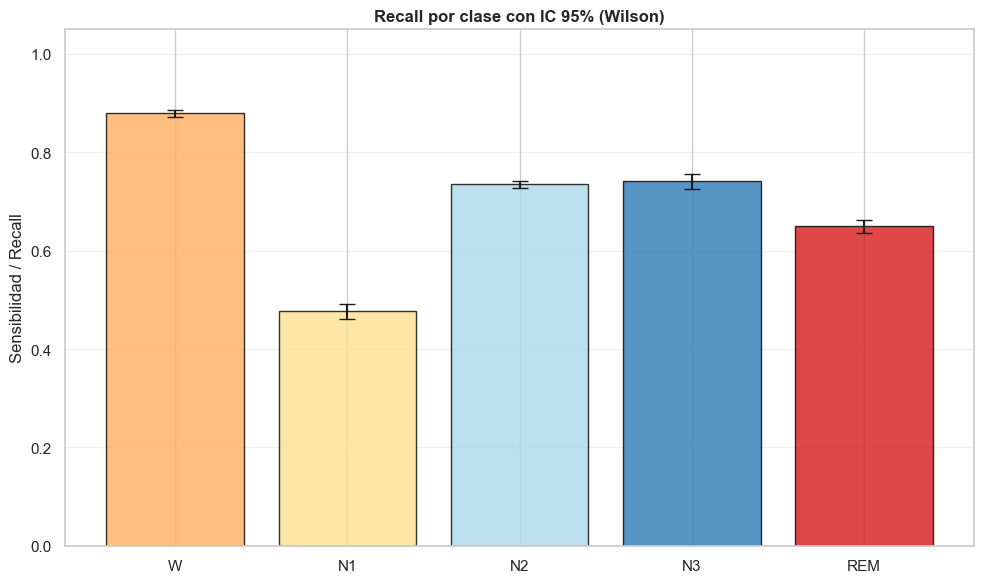


Pares de confusión más frecuentes:


,Verdadero,Predicho,Conteo,Proporción_sobre_clase
9,N2,N1,"2,016",16.05%
5,N1,N2,"1,080",26.56%
17,REM,N2,859,16.92%
0,W,N1,812,8.86%
14,N3,N2,802,25.00%


In [31]:
alpha = 0.05  # IC 95%
if "confusion_matrix" in metrics:
    cm = np.array(metrics["confusion_matrix"])
    class_metrics = compute_class_metrics(cm, labels=STAGE_ORDER, alpha=alpha)
    summary = summarize_class_metrics(class_metrics)

    # Distribución de soportes por clase
    support_df = class_metrics[["Stage", "support"]].copy()
    support_df["proportion"] = support_df["support"] / support_df["support"].sum()
    print("Distribución de soportes por clase:")
    display(
        support_df.style.format(
            {"support": "{:,.0f}", "proportion": "{:.2%}"}
        ).background_gradient(cmap="Purples", subset=["proportion"])
    )

    # Métricas por clase con IC 95% (Wilson)
    print("\nMétricas por clase con IC 95% (Wilson):")
    display(
        class_metrics[
            [
                "Stage",
                "precision",
                "recall",
                "specificity",
                "npv",
                "f1",
                "fpr",
                "fnr",
                "fdr",
                "recall_ci_low",
                "recall_ci_high",
                "spec_ci_low",
                "spec_ci_high",
            ]
        ]
        .rename(columns={"npv": "npv (TN rate)", "fpr": "fpr", "fnr": "fnr"})
        .style.format(
            {
                "precision": "{:.3f}",
                "recall": "{:.3f}",
                "specificity": "{:.3f}",
                "npv (TN rate)": "{:.3f}",
                "f1": "{:.3f}",
                "fpr": "{:.3f}",
                "fnr": "{:.3f}",
                "fdr": "{:.3f}",
                "recall_ci_low": "{:.3f}",
                "recall_ci_high": "{:.3f}",
                "spec_ci_low": "{:.3f}",
                "spec_ci_high": "{:.3f}",
            }
        )
        .background_gradient(
            cmap="YlGnBu",
            subset=["precision", "recall", "specificity", "npv (TN rate)", "f1"],
        )
    )

    # Resumen macro robusto y lift sobre azar
    print("\nResumen macro robusto:")
    summary_labels = {
        "balanced_accuracy": "Balanced accuracy (sensibilidad macro)",
        "macro_specificity": "Especificidad macro",
        "macro_precision": "Precisión macro",
        "macro_f1": "F1 macro",
        "gmean_sens_spec": "G-mean (sensibilidad x especificidad)",
        "chance_accuracy": "Azar (1/n clases)",
        "balanced_accuracy_lift": "Lift sobre azar (balanced acc)",
    }
    for key, label in summary_labels.items():
        value = summary.get(key, np.nan)
        if pd.isna(value):
            print(f"{label}: N/A")
        else:
            print(f"{label}: {value:.3f}")

    # Gráfico de sensibilidad por clase con IC 95%
    colors = [STAGE_COLORS.get(stage, "gray") for stage in STAGE_ORDER]
    fig, ax = plt.subplots(figsize=(10, 6))
    yerr = np.vstack(
        [
            class_metrics["recall"] - class_metrics["recall_ci_low"],
            class_metrics["recall_ci_high"] - class_metrics["recall"],
        ]
    )
    ax.bar(
        class_metrics["Stage"],
        class_metrics["recall"],
        color=colors,
        edgecolor="black",
        alpha=0.8,
        yerr=yerr,
        capsize=6,
    )
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Sensibilidad / Recall")
    ax.set_title("Recall por clase con IC 95% (Wilson)", fontweight="bold")
    ax.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Pares de confusión más frecuentes (errores sistemáticos)
    conf_df = most_confused_pairs(cm, labels=STAGE_ORDER, top_n=5)
    print("\nPares de confusión más frecuentes:")
    if not conf_df.empty:
        display(
            conf_df.style.format(
                {"Conteo": "{:,.0f}", "Proporción_sobre_clase": "{:.2%}"}
            ).background_gradient(
                cmap="Reds", subset=["Conteo", "Proporción_sobre_clase"]
            )
        )
    else:
        print("No se registran confusiones relevantes (fuera de la diagonal).")
else:
    print("No hay matriz de confusión disponible en las métricas.")

## Comparar múltiples modelos


✓ Cargado: random_forest
✓ Cargado: xgboost
✓ Cargado: cnn1d
✓ Cargado: lstm_unidir
✓ Cargado: lstm_bidir
✓ Cargado: lstm_bidir_attention

Total de modelos cargados: 6


,Modelo,Accuracy,Kappa,F1-macro,F1-weighted
0,random_forest,0.7282,0.6347,0.6950,0.7335
1,xgboost,0.7308,0.6412,0.7002,0.7374
2,cnn1d,0.7686,0.6802,0.7083,0.7743
3,lstm_unidir,0.6617,0.5296,0.5859,0.6585
4,lstm_bidir,0.6541,0.5211,0.5818,0.6624
5,lstm_bidir_attention,0.7464,0.6514,0.6807,0.7512


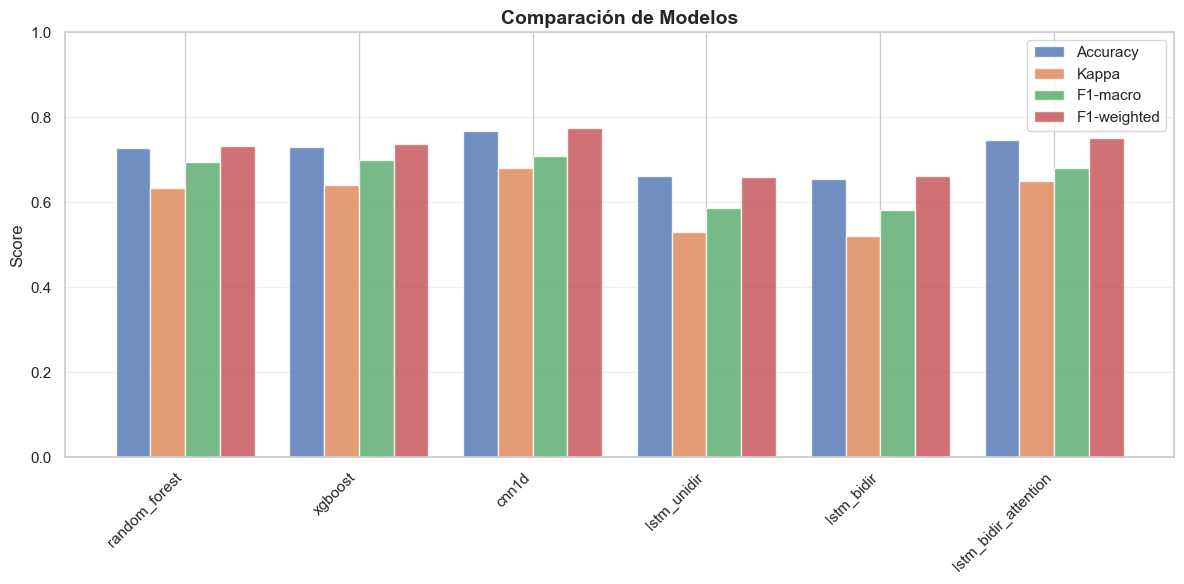

In [32]:
# Cargar métricas de todos los modelos disponibles
all_metrics = {}
for model_type, metrics_path in MODEL_PATHS.items():
    # Si es un directorio, buscar el archivo JSON dentro
    if metrics_path.is_dir():
        json_files = list(metrics_path.glob("*_results.json"))
        if json_files:
            metrics_path = json_files[0]
        else:
            continue

    if metrics_path.exists():
        all_metrics[model_type] = load_metrics(metrics_path)
        print(f"✓ Cargado: {model_type}")

print(f"\nTotal de modelos cargados: {len(all_metrics)}")

if len(all_metrics) > 1:
    # Comparar métricas generales
    comparison = []
    for name, m in all_metrics.items():
        if "metrics" in m:
            comparison.append(
                {
                    "Modelo": name,
                    "Accuracy": m["metrics"].get("accuracy", 0),
                    "Kappa": m["metrics"].get("kappa", 0),
                    "F1-macro": m["metrics"].get("f1_macro", 0),
                    "F1-weighted": m["metrics"].get("f1_weighted", 0),
                }
            )

    if comparison:
        df_comp = pd.DataFrame(comparison)
        display(
            df_comp.style.format(
                {
                    "Accuracy": "{:.4f}",
                    "Kappa": "{:.4f}",
                    "F1-macro": "{:.4f}",
                    "F1-weighted": "{:.4f}",
                }
            ).background_gradient(
                cmap="RdYlGn", subset=["Accuracy", "Kappa", "F1-macro", "F1-weighted"]
            )
        )

        # Gráfico comparativo
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(len(df_comp))
        width = 0.2

        metrics_to_plot = ["Accuracy", "Kappa", "F1-macro", "F1-weighted"]
        for i, metric in enumerate(metrics_to_plot):
            ax.bar(x + i * width, df_comp[metric], width, label=metric, alpha=0.8)

        ax.set_ylabel("Score", fontsize=12)
        ax.set_title("Comparación de Modelos", fontsize=14, fontweight="bold")
        ax.set_xticks(x + width * 1.5)
        ax.set_xticklabels(df_comp["Modelo"], rotation=45, ha="right")
        ax.legend()
        ax.grid(axis="y", alpha=0.3)
        ax.set_ylim([0, 1])

        plt.tight_layout()
        plt.show()
else:
    print("Necesitas al menos 2 modelos para comparar")

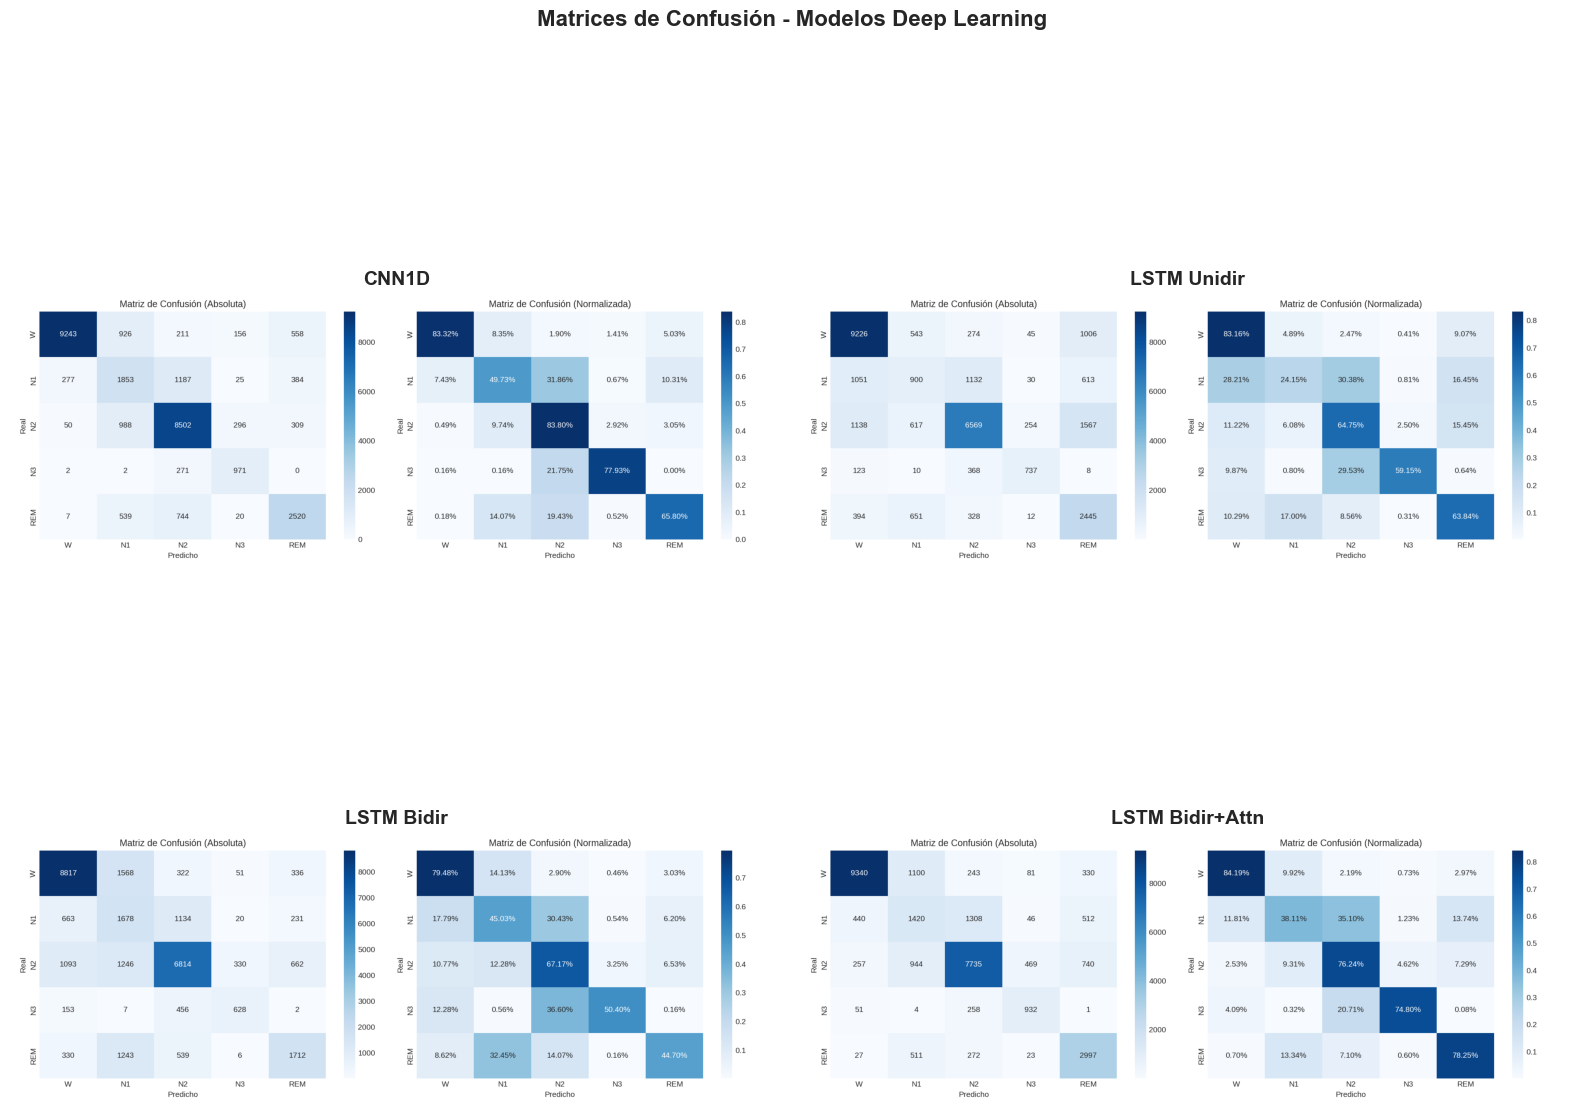

In [33]:
# Mostrar todas las matrices de confusión disponibles

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

cm_images = {
    "CNN1D": ARTIFACTS_DIR
    / "cnn1d_full_20251210_201502_artifacts"
    / "cnn1d_full_20251210_201502_confusion_matrix.png",
    "LSTM Unidir": ARTIFACTS_DIR
    / "lstm_full_unidir_artifacts"
    / "lstm_full_20251210_193039_confusion_matrix.png",
    "LSTM Bidir": ARTIFACTS_DIR
    / "lstm_full_bidir_artifacts"
    / "lstm_full_20251211_031820_confusion_matrix.png",
    "LSTM Bidir+Attn": ARTIFACTS_DIR
    / "lstm_full_bidir_attention_artifacts"
    / "lstm_full_20251211_145034_confusion_matrix.png",
}

for idx, (name, path) in enumerate(cm_images.items()):
    if idx >= len(axes):
        break
    if path.exists():
        img = mpimg.imread(str(path))
        axes[idx].imshow(img)
        axes[idx].set_title(name, fontsize=14, fontweight="bold")
        axes[idx].axis("off")
    else:
        axes[idx].text(0.5, 0.5, f"No encontrado:\n{name}", ha="center", va="center")
        axes[idx].axis("off")

plt.suptitle(
    "Matrices de Confusión - Modelos Deep Learning", fontsize=16, fontweight="bold"
)
plt.tight_layout()
plt.show()

---

# Analisis Avanzado

Las siguientes secciones amplian el analisis con metodologia estadistica rigurosa:
- Intervalos de confianza Bootstrap para metricas agregadas
- Analisis de variabilidad inter-sujeto
- Patrones de confusion y errores sistematicos
- Comparacion con benchmarks de literatura

Nota: las comparaciones estadisticas *pareadas* entre modelos requieren que los folds representen los mismos sujetos/particiones entre modelos (mapeo sujeto↔fold). Si esa condicion no se puede garantizar desde los artefactos, no se reportan p-valores pareados entre modelos.

In [34]:
# -----------------------------------------------------------------------------
# Funciones auxiliares para analisis estadistico avanzado
# -----------------------------------------------------------------------------


# Benchmarks de literatura para sleep staging
LITERATURE_BENCHMARKS = {
    "AASM_inter_scorer_kappa": 0.76,  # Rosenberg & Van Hout 2013
    "AASM_accuracy_range": (0.80, 0.85),  # Acuerdo tipico entre expertos
    "N1_f1_tipico": (0.30, 0.50),  # N1 es notoriamente dificil
    "sistemas_automaticos_sota_kappa": (0.70, 0.80),  # Estado del arte
}


def bootstrap_metric_from_cm(
    cm: np.ndarray,
    metric_fn,
    n_bootstrap: int = 1000,
    alpha: float = 0.05,
    random_state: int = 42,
) -> dict:
    """
    Calcula IC bootstrap (percentil) para una metrica a partir de la matriz de confusion.

    Importante: este bootstrap remuestrea *epocas* como i.i.d. (a nivel de observaciones).
    En datos de sueno, esto puede subestimar la incertidumbre por correlacion temporal y
    estructura por sujeto. Para inferencia inter-sujeto, preferi bootstrap sobre folds/sujetos.

    Implementacion eficiente: remuestreo multinomial sobre pares (y_true, y_pred), equivalente
    al bootstrap no parametrico sobre la distribucion empirica de pares en la CM.
    """
    cm = np.asarray(cm)
    if cm.ndim != 2 or cm.shape[0] != cm.shape[1]:
        return {
            "estimacion_puntual": np.nan,
            "ic_inferior": np.nan,
            "ic_superior": np.nan,
            "desvio_estandar": np.nan,
            "n_valid": 0,
            "warning": "confusion_matrix no es cuadrada",
        }
    n = int(cm.sum())
    if n <= 0:
        return {
            "estimacion_puntual": np.nan,
            "ic_inferior": np.nan,
            "ic_superior": np.nan,
            "desvio_estandar": np.nan,
            "n_valid": 0,
            "warning": "confusion_matrix vacia",
        }

    rng = np.random.default_rng(random_state)
    n_classes = cm.shape[0]
    flat = cm.reshape(-1).astype(float)
    probs = flat / n
    point_estimate = metric_fn(cm)

    bootstrap_metrics: list[float] = []
    for _ in range(n_bootstrap):
        try:
            sample_flat = rng.multinomial(n, probs)
            cm_boot = sample_flat.reshape(n_classes, n_classes)
            bootstrap_metrics.append(metric_fn(cm_boot))
        except Exception:
            continue

    if not bootstrap_metrics:
        return {
            "estimacion_puntual": float(point_estimate)
            if np.isfinite(point_estimate)
            else np.nan,
            "ic_inferior": np.nan,
            "ic_superior": np.nan,
            "desvio_estandar": np.nan,
            "n_valid": 0,
            "warning": "bootstrap fallo en todas las iteraciones",
        }

    bootstrap_metrics = np.asarray(bootstrap_metrics, dtype=float)
    lower = np.percentile(bootstrap_metrics, 100 * alpha / 2)
    upper = np.percentile(bootstrap_metrics, 100 * (1 - alpha / 2))
    return {
        "estimacion_puntual": float(point_estimate),
        "ic_inferior": float(lower),
        "ic_superior": float(upper),
        "desvio_estandar": float(np.std(bootstrap_metrics, ddof=1))
        if len(bootstrap_metrics) > 1
        else 0.0,
        "n_valid": int(len(bootstrap_metrics)),
    }


def bootstrap_ci_from_fold_scores(
    scores: list[float],
    n_bootstrap: int = 10000,
    alpha: float = 0.05,
    random_state: int = 42,
    agg=np.mean,
) -> dict:
    """
    IC bootstrap (percentil) para una estadistica agregada sobre folds/sujetos.

    Esto es mas coherente con inferencia inter-sujeto en LOSO que el bootstrap sobre epocas.
    """
    scores_arr = np.asarray(scores, dtype=float)
    scores_arr = scores_arr[np.isfinite(scores_arr)]
    if scores_arr.size < 2:
        return {
            "estimacion_puntual": np.nan,
            "ic_inferior": np.nan,
            "ic_superior": np.nan,
            "desvio_estandar": np.nan,
            "n_valid": 0,
            "warning": "insuficientes folds",
        }
    rng = np.random.default_rng(random_state)
    n = scores_arr.size
    boot = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        boot.append(float(agg(scores_arr[idx])))
    boot = np.asarray(boot, dtype=float)
    point = float(agg(scores_arr))
    return {
        "estimacion_puntual": point,
        "ic_inferior": float(np.percentile(boot, 100 * alpha / 2)),
        "ic_superior": float(np.percentile(boot, 100 * (1 - alpha / 2))),
        "desvio_estandar": float(np.std(boot, ddof=1)) if boot.size > 1 else 0.0,
        "n_valid": int(boot.size),
        "n_folds": int(n),
    }


def accuracy_from_cm(cm: np.ndarray) -> float:
    return np.trace(cm) / (cm.sum() + EPS)


def balanced_accuracy_from_cm(cm: np.ndarray) -> float:
    recalls = [cm[i, i] / (cm[i, :].sum() + EPS) for i in range(cm.shape[0])]
    return float(np.mean(recalls))


def kappa_from_cm(cm: np.ndarray) -> float:
    n = cm.sum()
    if n <= 0:
        return np.nan
    po = np.trace(cm) / n
    pe = np.sum(cm.sum(axis=0) * cm.sum(axis=1)) / (n**2)
    return (po - pe) / (1 - pe + EPS)


def macro_f1_from_cm(cm: np.ndarray) -> float:
    f1s = []
    for i in range(cm.shape[0]):
        tp = cm[i, i]
        fn = cm[i, :].sum() - tp
        fp = cm[:, i].sum() - tp
        precision = tp / (tp + fp + EPS)
        recall = tp / (tp + fn + EPS)
        f1 = 2 * precision * recall / (precision + recall + EPS)
        f1s.append(f1)
    return float(np.mean(f1s))


def f1_class_from_cm(cm: np.ndarray, class_idx: int) -> float:
    tp = cm[class_idx, class_idx]
    fn = cm[class_idx, :].sum() - tp
    fp = cm[:, class_idx].sum() - tp
    precision = tp / (tp + fp + EPS)
    recall = tp / (tp + fn + EPS)
    return 2 * precision * recall / (precision + recall + EPS)


print("Funciones de analisis avanzado cargadas correctamente")

Funciones de analisis avanzado cargadas correctamente


## Analisis de Variabilidad Inter-Sujeto

Analiza la variabilidad en el rendimiento del modelo entre diferentes sujetos/folds.
Esto es crucial para entender la generalizabilidad del modelo y detectar sujetos problematicos.


ANALISIS DE VARIABILIDAD INTER-SUJETO
Numero de folds (sujetos): 78
Score promedio: 0.6796 +/- 0.0985
Mediana: 0.7064
Rango: [0.4663, 0.8383]
Coeficiente de variacion: 14.49%

Rango intercuartil (IQR): 0.1433
Limites para outliers: [0.3875, 0.9606]
Folds outliers detectados: 0

Folds con clases faltantes en test: 6
  - Fold 33: faltan ['N3']
  - Fold 34: faltan ['N3']
  - Fold 63: faltan ['N3']
  - Fold 69: faltan ['N3']
  - Fold 70: faltan ['N3']


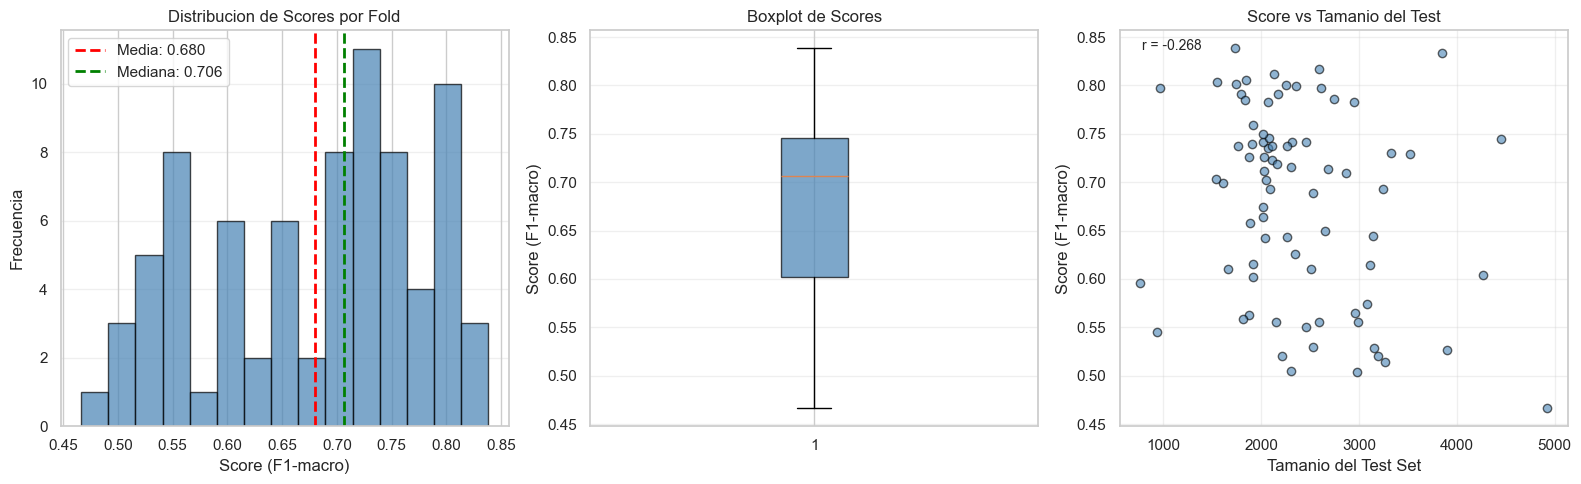


Distribucion por percentiles:


,Percentil,Score
0,5%,0.5193
1,25%,0.6024
2,50%,0.7064
3,75%,0.7456
4,95%,0.8067


In [35]:
# -----------------------------------------------------------------------------
# Analisis de variabilidad inter-sujeto (por fold LOSO)
# -----------------------------------------------------------------------------

if "cv_results" in metrics and "fold_metrics" in metrics["cv_results"]:
    fold_metrics_data = metrics["cv_results"]["fold_metrics"]
    scores = [fm["score"] for fm in fold_metrics_data]
    test_sizes = [fm["test_size"] for fm in fold_metrics_data]

    print("=" * 70)
    print("ANALISIS DE VARIABILIDAD INTER-SUJETO")
    print("=" * 70)

    scores_array = np.array(scores)

    print(f"Numero de folds (sujetos): {len(scores)}")
    print(f"Score promedio: {np.mean(scores):.4f} +/- {np.std(scores):.4f}")
    print(f"Mediana: {np.median(scores):.4f}")
    print(f"Rango: [{np.min(scores):.4f}, {np.max(scores):.4f}]")
    print(f"Coeficiente de variacion: {np.std(scores)/np.mean(scores):.2%}")

    # Detectar outliers (IQR)
    q1 = np.percentile(scores, 25)
    q3 = np.percentile(scores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = np.where((scores_array < lower_bound) | (scores_array > upper_bound))[0]

    print(f"\nRango intercuartil (IQR): {iqr:.4f}")
    print(f"Limites para outliers: [{lower_bound:.4f}, {upper_bound:.4f}]")
    print(f"Folds outliers detectados: {len(outliers)}")

    if len(outliers) > 0:
        print("\nDetalle de folds outliers:")
        for idx in outliers:
            fm = fold_metrics_data[idx]
            print(
                f"  - Fold {fm['fold']}: score={fm['score']:.4f}, test_size={fm['test_size']}"
            )

    # Folds con clases faltantes
    folds_missing = [fm for fm in fold_metrics_data if "missing_classes" in fm]
    if folds_missing:
        print(f"\nFolds con clases faltantes en test: {len(folds_missing)}")
        for fm in folds_missing[:5]:
            missing = fm["missing_classes"].get("test", [])
            print(f"  - Fold {fm['fold']}: faltan {missing}")

    # Graficos
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))

    ax = axes[0]
    ax.hist(scores, bins=15, color="steelblue", alpha=0.7, edgecolor="black")
    ax.axvline(
        np.mean(scores),
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Media: {np.mean(scores):.3f}",
    )
    ax.axvline(
        np.median(scores),
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Mediana: {np.median(scores):.3f}",
    )
    ax.set_xlabel("Score (F1-macro)")
    ax.set_ylabel("Frecuencia")
    ax.set_title("Distribucion de Scores por Fold")
    ax.legend()
    ax.grid(axis="y", alpha=0.3)

    ax = axes[1]
    bp = ax.boxplot(scores, vert=True, patch_artist=True)
    bp["boxes"][0].set_facecolor("steelblue")
    bp["boxes"][0].set_alpha(0.7)
    ax.set_ylabel("Score (F1-macro)")
    ax.set_title("Boxplot de Scores")
    ax.grid(axis="y", alpha=0.3)

    ax = axes[2]
    ax.scatter(test_sizes, scores, alpha=0.6, c="steelblue", edgecolor="black")
    ax.set_xlabel("Tamanio del Test Set")
    ax.set_ylabel("Score (F1-macro)")
    ax.set_title("Score vs Tamanio del Test")
    ax.grid(alpha=0.3)
    corr = np.corrcoef(test_sizes, scores)[0, 1]
    ax.annotate(
        f"r = {corr:.3f}", xy=(0.05, 0.95), xycoords="axes fraction", fontsize=10
    )

    plt.tight_layout()
    plt.show()

    print("\nDistribucion por percentiles:")
    percentiles_df = pd.DataFrame(
        [
            {"Percentil": "5%", "Score": np.percentile(scores, 5)},
            {"Percentil": "25%", "Score": np.percentile(scores, 25)},
            {"Percentil": "50%", "Score": np.percentile(scores, 50)},
            {"Percentil": "75%", "Score": np.percentile(scores, 75)},
            {"Percentil": "95%", "Score": np.percentile(scores, 95)},
        ]
    )
    display(percentiles_df.style.format({"Score": "{:.4f}"}))

elif "cv_results" in metrics and "scores" in metrics["cv_results"]:
    scores = metrics["cv_results"]["scores"]
    print("=" * 70)
    print("DISTRIBUCION DE SCORES DE CROSS-VALIDATION")
    print("=" * 70)
    print(f"Numero de folds: {len(scores)}")
    print(f"Score promedio: {np.mean(scores):.4f} +/- {np.std(scores):.4f}")

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.hist(scores, bins=15, color="steelblue", alpha=0.7, edgecolor="black")
    ax.axvline(
        np.mean(scores),
        color="red",
        linestyle="--",
        label=f"Media: {np.mean(scores):.3f}",
    )
    ax.set_xlabel("Score")
    ax.set_ylabel("Frecuencia")
    ax.set_title("Distribucion de Scores CV")
    ax.legend()
    plt.show()
else:
    print("No hay datos de cross-validation disponibles para este modelo")

## Analisis de Patrones de Confusion

Analiza los patrones de error entre estadios, identificando:
- Pares de confusion mas frecuentes
- Tasas de error en transiciones adyacentes
- Errores sistematicos del modelo


ANALISIS DE PATRONES DE CONFUSION
Top 10 pares de confusion:
--------------------------------------------------


,Verdadero,Predicho,Conteo,Tasa (%)
0,N2,N1,"2,016",16.05%
1,N1,N2,"1,080",26.56%
2,REM,N2,859,16.92%
3,W,N1,812,8.86%
4,N3,N2,802,25.00%
5,REM,N1,682,13.44%
6,N1,W,633,15.56%
7,N2,REM,570,4.54%
8,N2,N3,564,4.49%
9,N1,REM,369,9.07%



Confusiones en transiciones adyacentes (W-N1-N2-N3, REM):
--------------------------------------------------


,Transicion,Conteo,Tasa (%)
0,W -> N1,812,8.86%
1,N1 -> W,633,15.56%
2,N1 -> N2,"1,080",26.56%
3,N2 -> N1,"2,016",16.05%
4,N2 -> N3,564,4.49%
5,N3 -> N2,802,25.00%
6,N1 -> REM,369,9.07%
7,REM -> N1,682,13.44%
8,N2 -> REM,570,4.54%
9,REM -> N2,859,16.92%


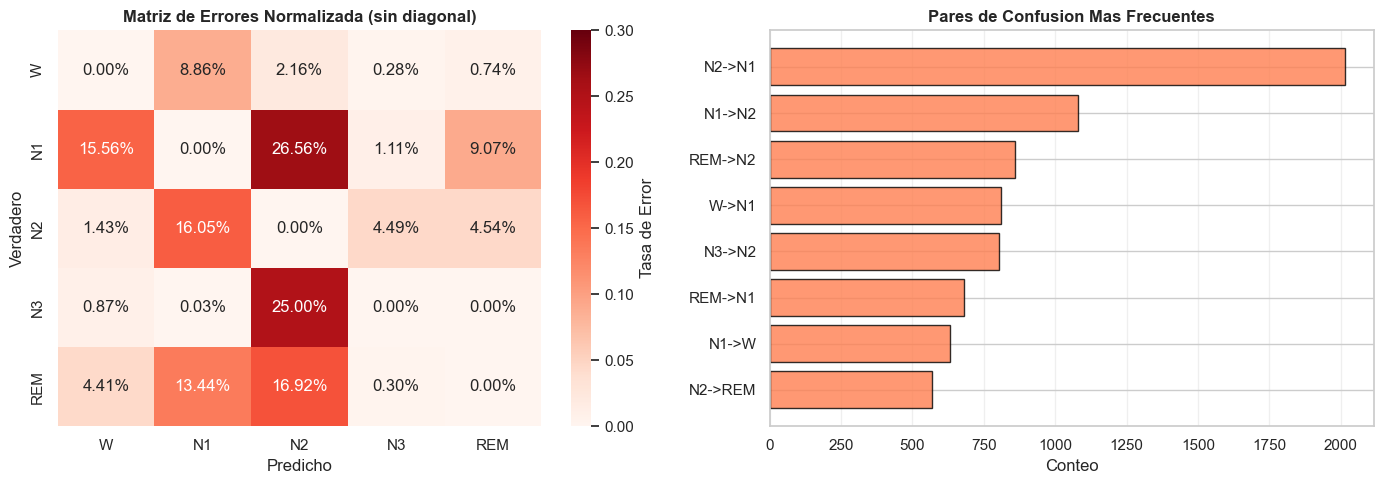


Interpretacion:
--------------------------------------------------
- Las confusiones N1<->N2 son esperables por similitud electroencefalografica
- Confusiones N2<->REM pueden indicar dificultad con husos de sueno vs. EEG REM
- Confusiones N3->N2 sugieren dificultad con ondas lentas de baja amplitud


In [36]:
# -----------------------------------------------------------------------------
# Analisis de patrones de confusion y errores sistematicos
# -----------------------------------------------------------------------------

if "confusion_matrix" in metrics:
    cm = np.array(metrics["confusion_matrix"])

    print("=" * 70)
    print("ANALISIS DE PATRONES DE CONFUSION")
    print("=" * 70)

    confusion_pairs = []
    for i, true_label in enumerate(STAGE_ORDER):
        row_sum = cm[i, :].sum()
        for j, pred_label in enumerate(STAGE_ORDER):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append(
                    {
                        "Verdadero": true_label,
                        "Predicho": pred_label,
                        "Conteo": int(cm[i, j]),
                        "Tasa (%)": 100 * cm[i, j] / (row_sum + EPS),
                    }
                )

    confusion_pairs.sort(key=lambda x: x["Conteo"], reverse=True)

    print("Top 10 pares de confusion:")
    print("-" * 50)
    conf_df = pd.DataFrame(confusion_pairs[:10])
    display(
        conf_df.style.format(
            {
                "Conteo": "{:,}",
                "Tasa (%)": "{:.2f}%",
            }
        ).background_gradient(cmap="Reds", subset=["Conteo", "Tasa (%)"])
    )

    print("\nConfusiones en transiciones adyacentes (W-N1-N2-N3, REM):")
    print("-" * 50)

    adjacent_pairs = [
        ("W", "N1"),
        ("N1", "W"),
        ("N1", "N2"),
        ("N2", "N1"),
        ("N2", "N3"),
        ("N3", "N2"),
        ("N1", "REM"),
        ("REM", "N1"),
        ("N2", "REM"),
        ("REM", "N2"),
    ]

    adjacent_data = []
    for true_stage, pred_stage in adjacent_pairs:
        i = STAGE_ORDER.index(true_stage)
        j = STAGE_ORDER.index(pred_stage)
        row_sum = cm[i, :].sum()
        adjacent_data.append(
            {
                "Transicion": f"{true_stage} -> {pred_stage}",
                "Conteo": int(cm[i, j]),
                "Tasa (%)": 100 * cm[i, j] / (row_sum + EPS),
            }
        )

    adj_df = pd.DataFrame(adjacent_data)
    display(
        adj_df.style.format(
            {
                "Conteo": "{:,}",
                "Tasa (%)": "{:.2f}%",
            }
        ).background_gradient(cmap="Oranges", subset=["Tasa (%)"])
    )

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    ax = axes[0]
    error_matrix = cm.copy().astype(float)
    np.fill_diagonal(error_matrix, 0)
    row_sums = cm.sum(axis=1, keepdims=True)
    error_matrix_norm = error_matrix / (row_sums + EPS)

    sns.heatmap(
        error_matrix_norm,
        annot=True,
        fmt=".2%",
        cmap="Reds",
        xticklabels=STAGE_ORDER,
        yticklabels=STAGE_ORDER,
        ax=ax,
        vmin=0,
        vmax=0.3,
        cbar_kws={"label": "Tasa de Error"},
    )
    ax.set_title("Matriz de Errores Normalizada (sin diagonal)", fontweight="bold")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Verdadero")

    ax = axes[1]
    top_pairs = confusion_pairs[:8]
    labels = [f"{p['Verdadero']}->{p['Predicho']}" for p in top_pairs]
    counts = [p["Conteo"] for p in top_pairs]

    y_pos = np.arange(len(labels))
    ax.barh(y_pos, counts, color="coral", alpha=0.8, edgecolor="black")
    ax.set_yticks(y_pos)
    ax.set_yticklabels(labels)
    ax.set_xlabel("Conteo")
    ax.set_title("Pares de Confusion Mas Frecuentes", fontweight="bold")
    ax.invert_yaxis()
    ax.grid(axis="x", alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nInterpretacion:")
    print("-" * 50)
    print(
        "- Las confusiones N1<->N2 son esperables por similitud electroencefalografica"
    )
    print(
        "- Confusiones N2<->REM pueden indicar dificultad con husos de sueno vs. EEG REM"
    )
    print("- Confusiones N3->N2 sugieren dificultad con ondas lentas de baja amplitud")
else:
    print("No hay matriz de confusion disponible")

## Comparacion con Benchmarks de Literatura

Compara el rendimiento del modelo con valores de referencia reportados en la literatura (orientativos):
- Kappa inter-evaluador AASM (~0.76)
- Accuracy tipico de expertos (80-85%)
- F1 tipico para N1 (30-50%)
- Rangos reportados para sistemas automaticos

Nota: estos valores no son estrictamente comparables si cambian dataset, protocolo de evaluacion, canales usados, preprocesamiento o criterio de etiquetado.

COMPARACION CON BENCHMARKS DE LITERATURA
Nota: comparacion orientativa; no implica equivalencia de protocolo/dataset.

Benchmarks de referencia (orientativos):
--------------------------------------------------
  Kappa inter-evaluador AASM: 0.76
  Rango accuracy expertos: (0.8, 0.85)
  Rango F1 tipico para N1: (0.3, 0.5)
  Rango kappa sistemas automaticos (reportado): (0.7, 0.8)

Resultados del modelo:
--------------------------------------------------
  Kappa: 0.6412 (< ref. AASM (orientativo), delta: -0.1188)
  Accuracy: 0.7308 (< limite inferior ref. (orientativo))
  F1 N1: 0.4076 (en rango ref. (orientativo))
  Kappa vs rango reportado (sistemas automaticos): por debajo del rango reportado (orientativo)


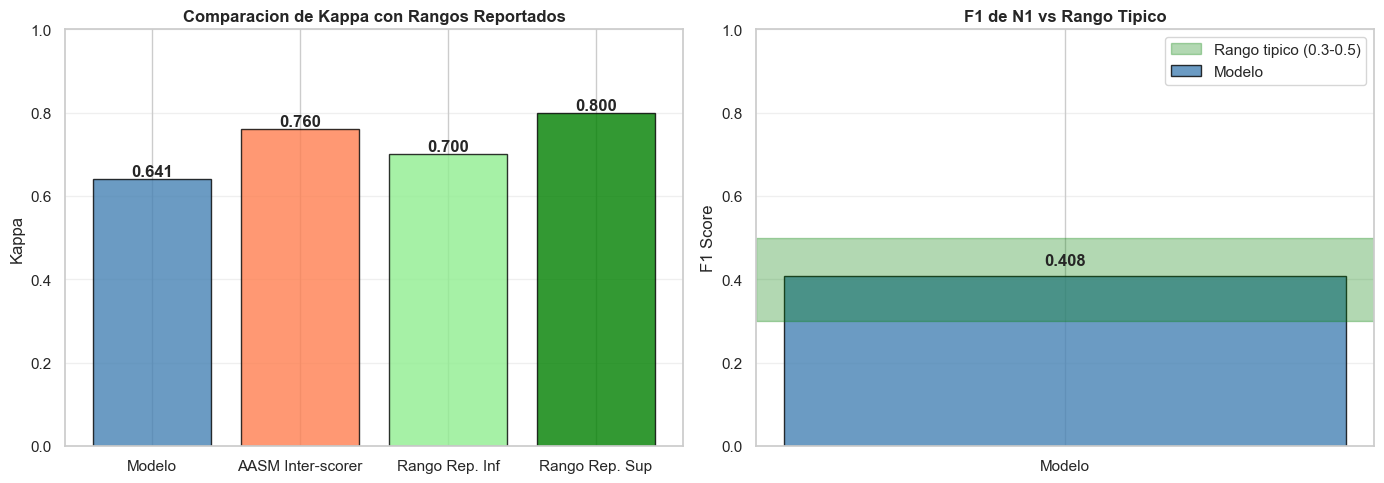


RESUMEN (COMPARACION ORIENTATIVA)
[INFO] Kappa 0.119 por debajo de referencia AASM (orientativo)
[INFO] Accuracy por debajo de referencia (orientativo)
[INFO] F1 de N1 en/por encima de referencia (orientativo)


In [37]:
# -----------------------------------------------------------------------------
# Comparacion con benchmarks de literatura
# -----------------------------------------------------------------------------

print("=" * 70)
print("COMPARACION CON BENCHMARKS DE LITERATURA")
print("=" * 70)
print("Nota: comparacion orientativa; no implica equivalencia de protocolo/dataset.")

kappa = metrics.get("metrics", {}).get("kappa", 0)
accuracy = metrics.get("metrics", {}).get("accuracy", 0)
f1_per_class = metrics.get("metrics", {}).get("f1_per_class", {})
n1_f1 = f1_per_class.get("N1", 0)

print("\nBenchmarks de referencia (orientativos):")
print("-" * 50)
print(
    f"  Kappa inter-evaluador AASM: {LITERATURE_BENCHMARKS['AASM_inter_scorer_kappa']}",
)
print(f"  Rango accuracy expertos: {LITERATURE_BENCHMARKS['AASM_accuracy_range']}")
print(f"  Rango F1 tipico para N1: {LITERATURE_BENCHMARKS['N1_f1_tipico']}")
print(
    f"  Rango kappa sistemas automaticos (reportado): {LITERATURE_BENCHMARKS['sistemas_automaticos_sota_kappa']}",
)

print("\nResultados del modelo:")
print("-" * 50)

aasm_kappa = LITERATURE_BENCHMARKS["AASM_inter_scorer_kappa"]
kappa_diff = kappa - aasm_kappa
kappa_status = (
    ">= ref. AASM (orientativo)" if kappa >= aasm_kappa else "< ref. AASM (orientativo)"
)
print(f"  Kappa: {kappa:.4f} ({kappa_status}, delta: {kappa_diff:+.4f})")

acc_range = LITERATURE_BENCHMARKS["AASM_accuracy_range"]
if accuracy >= acc_range[1]:
    acc_status = ">= limite superior ref. (orientativo)"
elif accuracy >= acc_range[0]:
    acc_status = "en rango ref. (orientativo)"
else:
    acc_status = "< limite inferior ref. (orientativo)"
print(f"  Accuracy: {accuracy:.4f} ({acc_status})")

n1_range = LITERATURE_BENCHMARKS["N1_f1_tipico"]
if n1_f1 >= n1_range[1]:
    n1_status = ">= limite superior ref. (orientativo)"
elif n1_f1 >= n1_range[0]:
    n1_status = "en rango ref. (orientativo)"
else:
    n1_status = "< limite inferior ref. (orientativo)"
print(f"  F1 N1: {n1_f1:.4f} ({n1_status})")

sota_range = LITERATURE_BENCHMARKS["sistemas_automaticos_sota_kappa"]
if kappa < sota_range[0]:
    sota_status = "por debajo del rango reportado (orientativo)"
elif kappa > sota_range[1]:
    sota_status = "por encima del rango reportado (orientativo)"
else:
    sota_status = "dentro del rango reportado (orientativo)"
print(f"  Kappa vs rango reportado (sistemas automaticos): {sota_status}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
bars = ax.bar(
    ["Modelo", "AASM Inter-scorer", "Rango Rep. Inf", "Rango Rep. Sup"],
    [
        kappa,
        LITERATURE_BENCHMARKS["AASM_inter_scorer_kappa"],
        LITERATURE_BENCHMARKS["sistemas_automaticos_sota_kappa"][0],
        LITERATURE_BENCHMARKS["sistemas_automaticos_sota_kappa"][1],
    ],
    color=["steelblue", "coral", "lightgreen", "green"],
    alpha=0.8,
    edgecolor="black",
)
ax.set_ylabel("Kappa")
ax.set_title("Comparacion de Kappa con Rangos Reportados", fontweight="bold")
ax.set_ylim(0, 1)
ax.grid(axis="y", alpha=0.3)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

ax = axes[1]
ax.bar(
    ["Modelo"],
    [n1_f1],
    color="steelblue",
    alpha=0.8,
    edgecolor="black",
    label="Modelo",
)
ax.axhspan(
    n1_range[0],
    n1_range[1],
    alpha=0.3,
    color="green",
    label=f"Rango tipico ({n1_range[0]}-{n1_range[1]})",
)
ax.set_ylabel("F1 Score")
ax.set_title("F1 de N1 vs Rango Tipico", fontweight="bold")
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis="y", alpha=0.3)
ax.text(
    0,
    n1_f1 + 0.02,
    f"{n1_f1:.3f}",
    ha="center",
    va="bottom",
    fontweight="bold",
)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("RESUMEN (COMPARACION ORIENTATIVA)")
print("=" * 70)

observaciones = []
if kappa >= aasm_kappa:
    observaciones.append("[INFO] Kappa >= referencia AASM (orientativo)")
else:
    gap = aasm_kappa - kappa
    observaciones.append(
        f"[INFO] Kappa {gap:.3f} por debajo de referencia AASM (orientativo)"
    )

if accuracy >= acc_range[0]:
    observaciones.append("[INFO] Accuracy en/por encima de referencia (orientativo)")
else:
    observaciones.append("[INFO] Accuracy por debajo de referencia (orientativo)")

if n1_f1 >= n1_range[0]:
    observaciones.append("[INFO] F1 de N1 en/por encima de referencia (orientativo)")
else:
    observaciones.append("[INFO] F1 de N1 por debajo de referencia (orientativo)")

for item in observaciones:
    print(item)

## Comparacion estadistica entre modelos (omitida)

Los tests pareados entre modelos (p.ej., Wilcoxon sobre scores por fold) solo son validos si los folds representan los mismos sujetos/particiones entre modelos (mapeo sujeto↔fold) y si los splits fueron generados con el mismo protocolo.

En los artefactos actuales no hay identificadores de sujeto por fold en todos los modelos (y no se puede garantizar el pareo), por lo que se omite el reporte de p-valores pareados entre modelos para evitar conclusiones invalidas.